# Homework 1. Likelihood-based models

- Seminar (5 points): Warmup
- Task 1 (10 points): PixelCNN
- Task 2 (10 points): Conditional PixelCNN
- **Task 3 (10 points): RealNVP**
- \* Bonus (10+++ points)

## Task 3. RealNVP

In this part, implement a simple, but fully operational RealNVP architecture to model flows from binary MNIST and shapes images to $N(0, I)$

Original paper: https://arxiv.org/abs/1605.08803

We recomment the following network design for affine coupling layer:

* 1x1 Conv2d
* ConvNeXt/ResNet/MobileNetBlock x3+
* 1x1 Conv2d

And the following hyperparameters:

* Batch size 128
* Learning rate $10^{-3}$
* 50+ epochs for shapes, 20+ epochs for MNIST
* AdamW Optimizer
* LayerNorm, if you need normalization for general networks

**Remember:** you must dequantize the data and scale it between -1 and 1 for the flow to have stable training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

In [16]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [2]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples', permute=True, binarize=None):
    if permute:
        samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    img = grid_img.permute(1, 2, 0).numpy()
    if binarize is not None:
        img = (img > binarize).astype(np.float32)
    plt.imshow(img)
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

First of all, let's create a function for checkerboard masking

In [5]:
def build_mask(size, mask_type=1):
    # if type == 1, the top left corner should be 1
    # if type == 0, the top left corner should be 0
    mask = np.arange(size).reshape(-1, 1) + np.arange(size)
    mask = np.mod(mask_type + mask, 2)
    mask = mask.reshape(-1, 1, size, size)
    return mask

In [12]:
mask0 = build_mask(2, 0)
assert np.allclose(build_mask(2, 1).flatten(), [1., 0., 0., 1.], atol=1e-6)
assert np.allclose(build_mask(2, 0).flatten(), [0., 1., 1., 0.], atol=1e-6)

Here you should build your RealNVP blocks

Fill the gaps, comments will help you

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, out_channels, internal=16):
        super(SimpleNet, self).__init__()
        
        ################
        # YOUR CODE HERE
        ###############
        self.net = # TODO
    
    def forward(self, x):
        return self.net(x)


class AffineCheckerboardTransform(nn.Module):
    def __init__(self, in_channels: int, size: int, mask_type=1):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = torch.tensor(build_mask(size, mask_type=mask_type).astype('float32')).to(device)
        self.scale = nn.Parameter(torch.ones(1), requires_grad=True)
        self.net = SimpleNet(in_channels, in_channels * 2)
        
    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.net(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s)
        # TODO: apply masking to the result

        if reverse:  # inverting the transformation
            # update x
        else:
            # update x
        return x, log_s


class AffineChannelTransform(nn.Module):
    def __init__(self, in_channels: int, modify_top: bool):
        super(AffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = SimpleNet(in_channels=in_channels, out_channels=in_channels * 2)

    def forward(self, x, reverse=False):
        n_channels = x.shape[1]
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1)
        else:
            off, on = x.split(n_channels // 2, dim=1)
        log_s, t = self.net(off).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s)

        if reverse:  # inverting the transformation
            # TODO: update on
        else:
            # TODO: update on

        if self.modify_top:
            return # TODO: x, logdet
        else:
            return # TODO: x, logdet

In [ ]:
# from Glow, you may use it as is
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(1, self.n_channels, 1,
                                                                                                 1))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

And RealNVP itself



In [41]:
class RealNVP(nn.Module):
    def __init__(self, in_channels, size):
        super(RealNVP, self).__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.size = size
        self.in_channels = in_channels
        self.out_size = size // 4
        self.out_channels = in_channels * 16
        
        self.checker_transforms1 = nn.ModuleList([
            ################
            # YOUR CODE HERE
            ###############
        ])

        self.channel_transforms = nn.ModuleList([
            ################
            # YOUR CODE HERE
            ###############
        ])

        self.checker_transforms2 = nn.ModuleList([
            ################
            # YOUR CODE HERE
            ###############
        ])

    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x
    
    def preprocess(self, x: torch.Tensor):
        # dequantize and normalize x here
        x = x.float()
        ################
        # YOUR CODE HERE
        ###############
        return x

    def reverse(self, z):
        # z -> x
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, reverse=True)
        return x

    def forward(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        # you have reverse implementation, forward can be recovered easily
        z, log_det = x, torch.zeros_like(x)
        ################
        # YOUR CODE HERE
        ###############
        return z, log_det

    def loss(self, x):
        x = self.preprocess(x)
        z, log_det = self.forward(x)
        logprob = # calculate logprob
        return -logprob.mean() / self.size / self.size / self.in_channels

    def sample(self, num_samples):
        with torch.no_grad():
            z = self.prior.sample([num_samples, self.out_channels, self.out_size, self.out_size])
            x = self.reverse(z)
            # TODO: invert your preprocessing (without quantization, of course)
            return x

In [42]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x, _ in train_loader:
        x = x.cuda()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.cuda()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_data, test_data, model, dataset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss
    dataset_id: in case you want to adjust some settings for each dataset separately 
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    ################
    # YOUR CODE HERE
    ###############

### First dataset: **Shapes** (5 points)

Our reference loss is ~0.84 on test, lower is better

In [43]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl

In [44]:
shapes_train, shapes_test = load_data('./shapes.pkl')

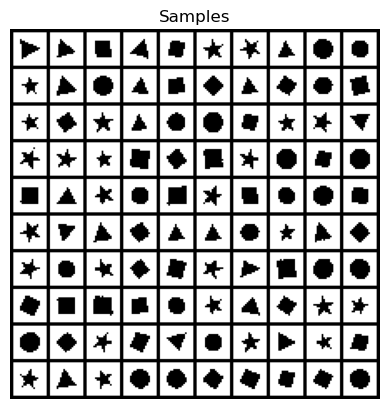

In [45]:
show_samples(shapes_train[:100])

In [46]:
shapes_train.shape

(10479, 20, 20, 1)

In [ ]:
H, W, _ = shapes_train[0].shape
model = RealNVP(1, H)
train_losses, test_losses, shapes_model = train_model(shapes_train, shapes_test, model, 'shapes')

In [48]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.ylim(0.4, 2)
    plt.show()

In [ ]:
show_train_plots(train_losses, test_losses, 'Shapes')

In [50]:
samples = shapes_model.sample(100).cpu()

In [ ]:
show_samples(samples, permute=False)

In [ ]:
# threshold depends on your model and (de)normalization
show_samples(samples, permute=False, binarize=0.7)

### Second dataset: MNIST (5 points)

Our reference loss is ~0.83 on test

In [ ]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

In [52]:
mnist_train, mnist_test = load_data('./mnist.pkl')

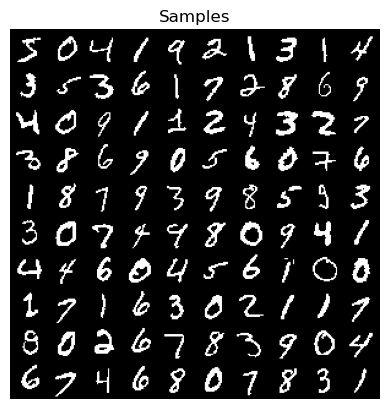

In [53]:
show_samples(mnist_train[:100])

In [ ]:
H, W, _ = mnist_train[0].shape
model = RealNVP(1, H)
train_losses, test_losses, mnist_model = train_model(mnist_train, mnist_test, model, 'mnist')

In [ ]:
show_train_plots(train_losses, test_losses, 'MNIST')

In [ ]:
samples = mnist_model.sample(100).cpu()
show_samples(samples, permute=False)

In [ ]:
# threshold depends on your model and (de)normalization
show_samples(samples, permute=False, binarize=0.8)